In [1]:
import numpy as np
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import wp
from halotools.empirical_models import PrebuiltHodModelFactory,  Zheng07Cens, Zheng07Sats, TrivialPhaseSpace,NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
from astropy.cosmology import FlatLambdaCDM
from tabcorr import TabCorr
import emcee
import warnings
warnings.filterwarnings("ignore")
import scipy.constants as sc
import scipy.stats as ss

In [8]:
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115) # smdpl
param = 'vmax'
threshold=19
dname = '21'
Lbox = 400

In [6]:
#halocat = CachedHaloCatalog(simname='bolplanck')
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
#model_instance = PrebuiltHodModelFactory('zheng07')

In [11]:
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
vmax = halocat.halo_table['halo_vmax']
G = sc.gravitational_constant
vvir = (G*mvir/rvir)**0.5
vmax_ml = (10**(np.log10(halocat.halo_table['halo_vmax'])*(m)+(b)))

NameError: name 'm' is not defined

In [ ]:
halocat.halo_table.add_column(vmax_ml, name = 'vmax_ml')
if param == 'mvir':
    print('mvir')
    cens_occ_model = Zheng07Cens(threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
else:
    print('vmax')
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)

model_instance.populate_mock(halocat) 


In [10]:
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20_noGW' in dname:
    print('20 noGW')
    import zehavi_data_file_20_noGW
    wp_ng_vals = zehavi_data_file_20_noGW.get_wp()[0:12]
    bin_edges = zehavi_data_file_20_noGW.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20_noGW.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    ng_err = 0.00007
elif 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
elif 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
invcov = np.linalg.inv(cov_matrix)


In [71]:
halotab = TabCorr.read('smdpl_vmax.hdf5')


In [42]:
ngal, wp = halotab.predict(model_instance)

[409.48211215 261.32274231 169.89549764 113.05953934  73.91752265
  49.56826681  34.21599742  24.73272755  17.27091456  11.08293303
   6.50134646]


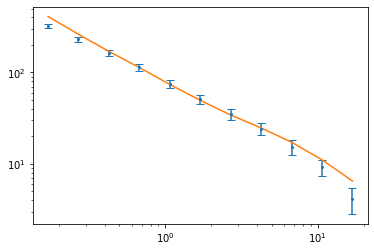

In [43]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
plt.plot(bin_cen, wp, label='total')
plt.xscale('log')
plt.yscale('log')

In [47]:
#log liklihood
def lnlike(theta):
    logMmin, sigma_logM, alpha, logM0, logM1 = theta
    cens_occ_model.param_dict['logMmin'] = logMmin
    cens_occ_model.param_dict['sigma_logM'] = sigma_logM
    sats_occ_model.param_dict['alpha'] = alpha
    sats_occ_model.param_dict['logM0'] = logM0
    sats_occ_model.param_dict['logM1'] = logM1
        
    ngal, wp = halotab.predict(model_instance)
    wp_diff = wp_ng_vals[1:12]-wp
    ng_diff = wp_ng_vals[0]-ngal
    
    return -0.5*np.dot(wp_diff, np.dot(invcov, wp_diff)) + -0.5*(ng_diff**2)/(ng_err**2)

#log prior
def lnprior(theta):
    logMmin_r = [1.0,4.0]
    sigma_logM_r = [0.01,2.0]
    alpha_r = [0.5,3.0]
    logM0_r = [1.0,4.0]
    logM1_r = [1.0,4.0]
    
    logMmin, sigma_logM, alpha, logM0, logM1 = theta
    if logMmin_r[0]<logMmin<logMmin_r[1] and sigma_logM_r[0]<sigma_logM<sigma_logM_r[1] and alpha_r[0]<alpha<alpha_r[1] and logM0_r[0]<logM0<logM0_r[1] and logM1_r[0]<logM1<logM1_r[1]:
        return 0.0
    return -np.inf

#log prop
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf

    ll = lnlike(theta)
    return lp + ll

In [ ]:
nwalkers = 10
ndim = 5
nsteps = 5
guess = [2.13, 0.22, 3.08, 1.47, 2.45]
pos = [guess+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
backend = emcee.backends.HDFBackend('test.h5')
backend.reset(nwalkers, ndim)                                                        
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                        backend=backend)                                                             
sampler.run_mcmc(pos, nsteps, progress=True, store=True)


In [46]:
reader = emcee.backends.HDFBackend('test.h5', read_only=True)

In [ ]:
reader.get_chain(discard=0, flat=False, thin=1)

# Conversions

In [72]:
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
vmax = halocat.halo_table['halo_vmax']
G = sc.gravitational_constant
vvir = (G*mvir/rvir)**0.5


In [12]:
print(vvir[0],mvir[0],vmax[0])
print(np.log10(vvir[0]),np.log10(vmax[0]),np.log10(mvir[0]))

106.1035 200800000000000.0 1001.57
2.0257297 3.0006814 14.302764


In [13]:
m, b, r, p, se = ss.linregress(np.log10(vmax), np.log10(mvir))
m,b

(3.2129514846864926, 4.71149353971438)

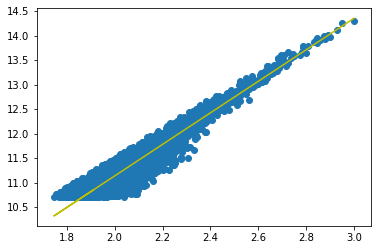

In [14]:
plt.scatter(np.log10(vmax[0:10_000]),np.log10(mvir[0:10_000]))
plt.plot(np.log10(vmax[0:10_000]),np.log10(vmax[0:10_000])*(m)+(b),c='y')
#plt.yscale('log')
#plt.xscale('log')

In [15]:
##CONVERT FROM VMAX TO MASS LIKE
vmax_ml = (10**(np.log10(halocat.halo_table['halo_vmax'])*(m)+(b)))
#print(10**(np.log10(100)*(m)+(b)),halocat.particle_mass)
#convert Vmax param vals to masslike
        #logVmaxMin, LogVmax0, LogVmax1
vals = [2.71201315,2.74328734,2.886974  ]
for v in vals:
    print(np.log(10**(np.log10(v)*(m)+(b))))
alpha_v = 2.22089537
sigma_v = 0.11299189
alpha_m = alpha_v/m
sigma_m = m*sigma_v
print(alpha_m)
print(sigma_m)

14.054148273263985
14.090987144445135
14.255014532754634
0.6912321523014552
0.36303746073303284


In [127]:
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'vmax_ml',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'vmax_ml',threshold=threshold)#, modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

mean_ncen_vml = cens_occ_model.mean_occupation(prim_haloprop=halocat.halo_table['vmax_ml'])
mean_nsat_vml = sats_occ_model.mean_occupation(prim_haloprop=halocat.halo_table['vmax_ml'])

In [128]:
cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax',threshold=threshold)
cens_prof_model = TrivialPhaseSpace()
sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax',threshold=threshold)#, modulate_with_cenocc=True,threshold=threshold)
sats_prof_model = NFWPhaseSpace()
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

mean_ncen_v = cens_occ_model.mean_occupation(table=halocat.halo_table)
mean_nsat_v = sats_occ_model.mean_occupation(table=halocat.halo_table)

(0.1, 100)

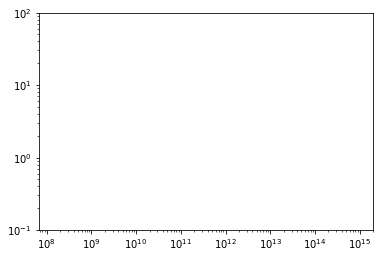

In [129]:
#plt.semilogy(vmax_ml[0:int(0.99e5)],mean_nsat[0:int(0.99e5)],ls='', marker='.')
plt.semilogy(vmax_ml[0:int(0.99e5)],mean_nsat_v[0:int(0.99e5)],ls='', marker='.')
plt.xscale('log')
plt.ylim(0.1,100)

Find Vmax cut off for TabCorr

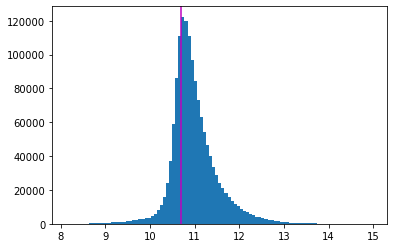

In [24]:
bins = np.linspace(np.min(np.log10(vmax_ml[0:100000])),np.max(np.log10(vmax_ml[0:100000])),100)
counts,bins,patches = plt.hist(np.log10(vmax_ml),bins=bins)
plt.axvline(bins[np.where(counts == np.max(counts))],c='m')


In [25]:
10**(bins[np.where(counts == np.max(counts))])


array([5.07746568e+10])